# Shelter Animal Outcomes
### Talieh, John, Sean, Subhashini

In [194]:
from datetime import date, datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.cross_validation import KFold

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import cross_validation

from patsy import dmatrices, dmatrix

In [2]:
train_data = pd.read_csv('train.csv', parse_dates=['DateTime'])
test_data = pd.read_csv('test.csv', parse_dates=['DateTime'])

n_train_data = len(train_data.index)

## 1. Data Exploration

In [3]:
# Utility functions
# From: http://stackoverflow.com/a/28688724
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('4-winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('1-spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('2-summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('3-autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('4-winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

### For simplicity sake, and for the exploration of the data set, we are combining the training and submission data.

In [4]:
feature_columns = ['AnimalID', 'Name', 'DateTime', 'AnimalType', 'SexuponOutcome', 
                    'AgeuponOutcome', 'Breed', 'Color', 'OutcomeType']

train_features = train_data.loc[:, feature_columns]
test_features = test_data.loc[:, feature_columns]

data = pd.concat((train_features, test_features), ignore_index=True)

In [5]:
data['Season'] = data.DateTime.map(get_season)

data['Sex X Species'] = data.SexuponOutcome + ' ' + data.AnimalType

data['Month'] = data.DateTime.apply(lambda d: d.strftime('%m-%B'))   # 'January', 'Feburary', . . .
data['WeekDay'] = data.DateTime.apply(lambda d: d.strftime('%w-%A')) # 'Sunday', 'Monday', . . .  

In [6]:
train_data = data[:n_train_data]
test_data = data[n_train_data:]

print 'Size of training set: %d' % len(train_data.index)
print 'Size of submission set: %d' % len(test_data.index)

Size of training set: 26729
Size of submission set: 11456


### Comparing train and test data distributions

In [7]:
train_data.describe()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeType,Season,Sex X Species,Month,WeekDay
count,26729,19038,26729,26729,26728,26711,26729,26729,26729,26729,26728,26729,26729
unique,26729,6374,22918,2,5,44,1380,366,5,4,10,12,7
top,A705677,Max,2015-08-11 00:00:00,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White,Adoption,3-autumn,Neutered Male Dog,10-October,6-Saturday
freq,1,136,19,15595,9779,3969,8810,2824,10769,7777,6714,2881,4348
first,NaN,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-02-21 19:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Utility functions for plotting

In [8]:
# Function to plot bar charts of categorical variables, with 
# train and test bars side-by-side. Hard-coded to use data from global env
def barplot_testvtrain(field_name):
    train_size = len(train_data.index) * 1.0
    test_size = len(test_data.index) * 1.0

    train_dist = train_data.groupby(field_name).size() / train_size
    test_dist = test_data.groupby(field_name).size() / test_size
    
    indices = np.arange(train_dist.size)
    width = .35
    
    fig, ax = plt.subplots()
    plt.title('{} distribution'.format(field_name))
    
    train_rects = ax.bar(indices, train_dist, width, color='r')
    test_rects = ax.bar(indices + width, test_dist, width, color='b')

    ax.set_xticks(indices + width)
    ax.set_xticklabels(train_dist.index, rotation=45)

    ax.legend((train_rects[0], test_rects[0]), ('Train', 'Test'), loc=0)
    plt.show()
    
# Function to generate stacked bar charts of outcome v. categorical variable,
# hard-coded to use data from global env
def barplot_stacked(field_name):
    # Making a copy of the data to use for plotting.
    # Copy is needed 'cuz I'm dropping NAs.
    plot_data = pd.DataFrame()
    plot_data[field_name] = train_data[field_name]
    plot_data['OutcomeType'] = train_data.OutcomeType
    plot_data = plot_data.dropna()

    # List of outcomes in order to stack, together with assigned color
    outcomes = [('Adoption', 'r'), 
                ('Transfer', 'b'), 
                ('Return_to_owner', 'g'), 
                ('Euthanasia', 'y'), 
                ('Died', 'm')]

    # Getting information about the categories in the variable
    categories = plot_data[field_name].unique()
    categories.sort()
    cat_counts = plot_data.groupby(field_name).size()
    indices = np.arange(categories.size)
    
    width = .75
    barsets = []
    
    # Series of 0s for all categories, added to distributions
    # to ensure that there's an entry for every category.
    zero = pd.Series({c:0 for c in categories})
    # Keeps track of bottoms. Bottoms are just top of previous one.
    bottoms = pd.Series({c:0 for c in categories})

    fig, ax = plt.subplots()
    plt.title('Outcomes by {}'.format(field_name))

    # Loop over outcomes, generate bars, and stack them
    for outcome, c in outcomes:
        dist = plot_data.loc[plot_data.OutcomeType == outcome] \
                         .groupby(field_name) \
                         .size() \
                         / cat_counts
                    
        dist = zero.add(dist, 'index', fill_value=0.0)

        # Saving barset for later because it's needed to draw the legend
        bs = ax.bar(indices, dist, width, color=c, bottom = bottoms)
        barsets.append(bs)
        
        # The bottom of the next round of bars will be the top of this one.
        bottoms = bottoms.add(dist, 'index', fill_value=0.0)

    # Drawing category labels
    ax.set_xticks(indices + (width / 2))
    ax.set_xticklabels(categories, rotation=90)
    
    ax.set_ylim(0, 1)
    # Drawing legend outside of plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend([bs[0] for bs in barsets], 
              [n[0] for n in outcomes], 
              loc='center left', 
              bbox_to_anchor=(1, 0.5))
    
    plt.show()

### Comparing the training to the submission data to see if they are balanced.

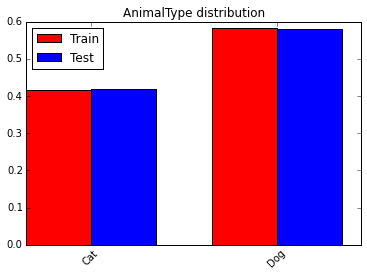

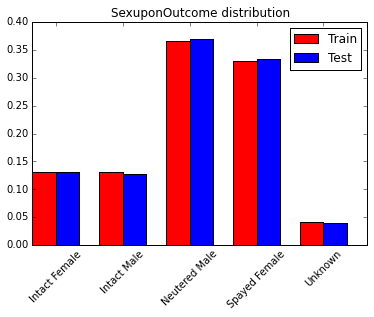

In [9]:
barplot_testvtrain('AnimalType')
barplot_testvtrain('SexuponOutcome')

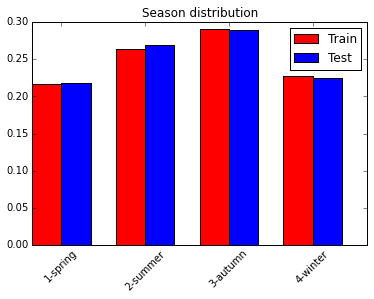

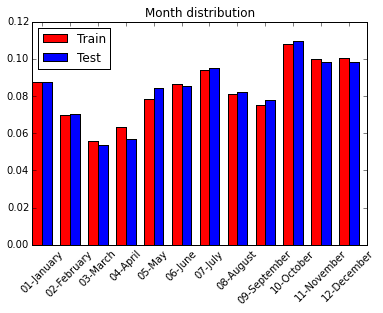

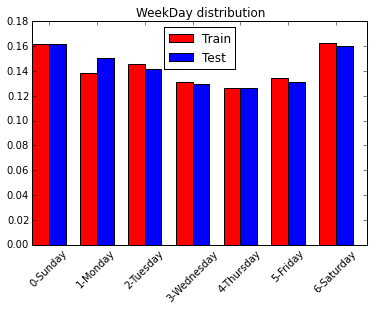

In [10]:
barplot_testvtrain('Season')
barplot_testvtrain('Month')
barplot_testvtrain('WeekDay')

### Are there any immediately apparent trends in the data?

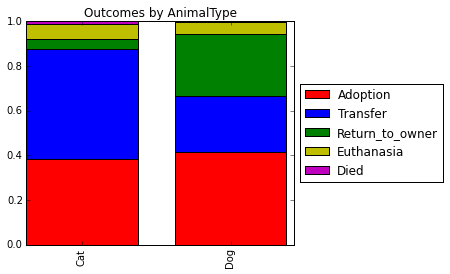

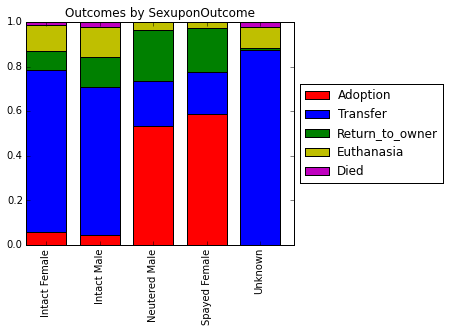

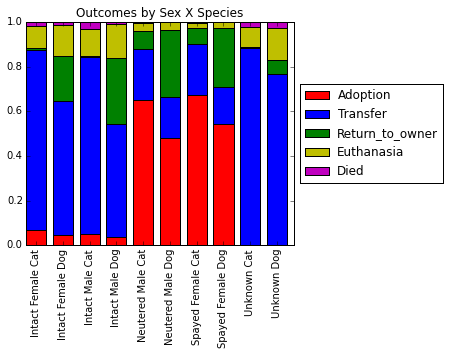

In [11]:
barplot_stacked('AnimalType')
barplot_stacked('SexuponOutcome')
barplot_stacked('Sex X Species')

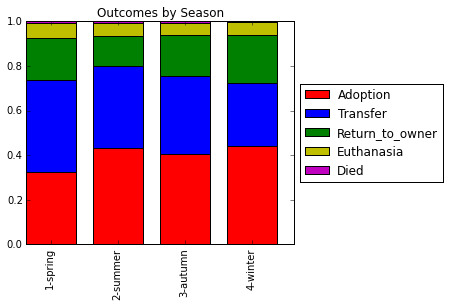

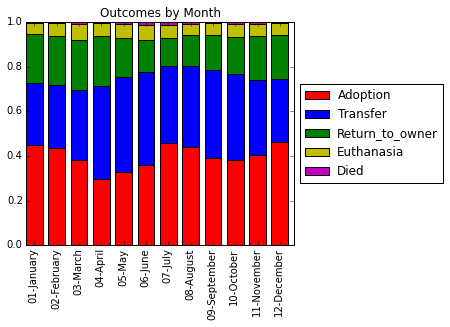

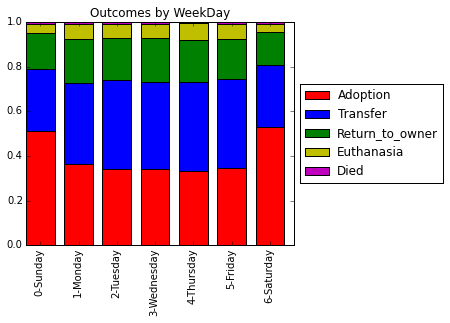

In [12]:
barplot_stacked('Season')
barplot_stacked('Month')
barplot_stacked('WeekDay')

## 2. Feature Selection and Model Testing

### Multiple approaches to feature engineering were attempted

**Common Utility Functions**

In [149]:
# There are two differing versions of the age function

def age_years(x):
    # We want to skip nan's
    try:
        age = int(x.split(' ')[0])

        if 'month' in x:
            age /= 12.0

        elif 'week' in x:
            age /= 52.0

        elif 'day' in x:
            age /= 365.0

        else:
            age = float(age)

        return age
    except AttributeError:
        return x
    
def age_years_2(x):
    if(pd.isnull(x)):
        return 0
    
    age = int(x.split(' ')[0])
        
    if 'month' in x:
        age /= 12.0

    elif 'week' in x:
        age /= 52.0

    elif 'day' in x:
        age /= 365.0

    elif 'year' in x:
        age = age
    else:
        age = 0

    return age


# There are two differing versions of the bread function

def get_breed_1(line):
    #special case this miscoded value : should be Black and Tan hound Mix (Black and Tan hound is a breed)
    if line == 'Black/Tan Hound Mix':
        return 'purebreed_mix'
        
    if '/' in line:
        breed2 = line.split('/')[1]
        if 'unknown' in breed2:
            return 'purebreed_unknown'
        else:
            return 'purebreed_purebreed'
    elif 'unknown' in line:
        return "unknown"
    elif 'mix' in line:
      return "purebreed_mix"
    else:
        return "purebreed"

def get_breed_0(line):
    # mix is the last word
    l = line.split('/')
    mix = 1 if 'Mix' in line else 0
    
    if mix:
        l = line.split(' ')
        # remove 
        del l[-1]
        l = ' '.join(l).split('/')

    if len(l) == 2:
        # remember We need to return series to add to multiple columns
        return pd.Series({'breed_1': l[0], 'breed_2': l[1], 'is_mix': mix})

    return pd.Series({'breed_1': l[0], 'breed_2': 'NaN', 'is_mix': mix})

def get_color(x):
    if pd.isnull(x):
        return x
    colors = x.strip().split('/')
    if len(colors) == 1:
        return "single_color"
    elif len(colors) == 2:
        return "double_color"
    else:
        return "twoplus_color"
    
    
def gender(string):
    try:
        if 'Female' in string:
            return 1

        if 'Male' in string:
            return 0
        
        return -999

    except:
        return -999
    
def fixed(string):
    try:
        if 'Spayed' in string or 'Neutered' in string:
            return 1

        if 'Unknown' in string:
            return -999

        return 0
    except:
        return -999
    
def draw_cm(y_true, y_pred,label_names):
    
    def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(label_names))
        plt.xticks(tick_marks, label_names, rotation=45)
        plt.yticks(tick_marks, label_names)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    cm = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm)
    
# use K-fold cross validation with k=6

def fit_model(clf):
    labels =  train_labels.cat.categories
    
    kf = KFold(train_data.shape[0], n_folds=6)

    ypp = []
    mll = []
    idx = 0
    for train_index, test_index in kf:
        X_train, X_test = train_data.iloc[train_index], train_data.iloc[test_index]
        y_train, y_test = train_labels.iloc[train_index], train_labels.iloc[test_index]
        #print X_train.shape, X_test.shape
        clf.fit(X_train, y_train)
        ypp.append(clf.predict_proba(X_test))
        mll.append(metrics.log_loss(y_test, ypp[idx]))
        idx += 1

    print "Log Loss (each iteration) :\n", '\n'.join([str(x) for x in mll])
    print "Std Deviation Log Loss :\n", np.std(mll)
    
    # Get the highest probability value
    y_pred = labels[np.argmax(np.vstack(ypp), axis=1)]
    
    print metrics.classification_report(train_labels, y_pred)
    draw_cm(train_labels, y_pred, labels)
    
def draw_rf_importances(clf, n_features = 50):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)

    indices = np.argsort(importances)[::-1]

    print 'Top features: '
    print train_data.columns.values[indices[:n_features]]

    # We have some many features let's 
    # just look at the first n_features
    plt.figure(figsize=(10,10))
    plt.title("Feature importances, first %d" % n_features)
    plt.bar(range(n_features),
            importances[indices][:n_features],
            color="g",
            yerr=std[indices][:n_features],
            align="center")

    plt.xticks(range(n_features), indices, rotation=70)

    plt.xlim([-1, n_features])
    plt.xlabel('Feature Indices')
    plt.grid()
    plt.show()

### This is common to all the approches to creating features

In [47]:
# read in fresh train and test data
train = pd.read_csv('train.csv', parse_dates=['DateTime'])
test = pd.read_csv('test.csv', parse_dates=['DateTime'])

# get number of training elements
train_num = train.shape[0]

train.rename(columns={'AnimalID': 'ID'}, inplace=True)
all_data = pd.concat((train, test), axis=0, ignore_index=True)

### Feature Set V1

In [48]:
# create a new data frame to store our new features.
fsv1 = pd.DataFrame()

#We need an index to work with
fsv1['ID'] = all_data['ID']

# is it a cat?
fsv1['is_cat'] = all_data['AnimalType'].map(lambda x: 1 if 'Cat' in x else 0) 

# color stuff
fsv1 = fsv1.join(all_data['Color'].apply(
        lambda x: pd.Series({'color_1':x.split('/')[0], 'color_2':x.split('/')[1]}
                            if len(x.split('/')) == 2 else {'color_1':x, 'color_2':'NaN'})))

# Convert the date into seasons

fsv1['Season'] = data.DateTime.map(get_season)
fsv1 = fsv1.join(pd.get_dummies(all_data['DateTime'].map(get_season)))

# Add in the breed information
fsv1 = fsv1.join(all_data['Breed'].apply(lambda x: get_breed_1(x)))

fsv1['age_years'] = all_data['AgeuponOutcome'].map(age_years)

# what is the gender, I am coding all unknowns as -999
fsv1['is_female'] = all_data['SexuponOutcome'].map(gender)

fsv1['is_fixed'] = all_data['SexuponOutcome'].map(fixed)

***In this case it's ok to dummy code the breed across the entire data set because there are only three possible values ***

In [49]:
fsv1 = fsv1.join(pd.get_dummies(fsv1['Breed']))

***But because there are a wide assortment of colors, it seems to make more sense to split the data up and avoid information leakage.***

In [61]:
# Lets break things back up before continuing 
X_train_all = fsv1.iloc[:train_num]
y_train_all = all_data['OutcomeType'][:train_num]

# Submission data
X_test_all = fsv1.iloc[train_num:]
ids_test = all_data['ID'][train_num:].values

X_train_all.shape, y_train_all.shape, X_test_all.shape, ids_test.shape

X_train, X_test, y_train, y_test = train_test_split(
    X_train_all, y_train_all, test_size=0.30, random_state=23)

In [62]:
# vectorize the colors using our training data
cv = CountVectorizer(analyzer='word')
cv.fit(X_train['color_1'])

CountVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [63]:
X_train = X_train.join(pd.DataFrame(
        cv.transform(X_train['color_1']).todense(),
        index=X_train.index.values,
        columns=[x+'_1' for x in cv.get_feature_names()]))

In [64]:
X_test = X_test.join(pd.DataFrame(
        cv.transform(X_test['color_1']).todense(),
        index=X_test.index.values,
        columns=[x+'_1' for x in cv.get_feature_names()]))

In [65]:
# We want to drop the original non-binary columns now.
cols_to_drop = ['color_1',
                'color_2',
                'Breed',
                'Season',
                'ID']

X_train = X_train.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)

X_train = X_train.fillna(value=-999)
X_test = X_test.fillna(value=-999)

In [66]:
# Quick Test
lr = LogisticRegression(random_state=23, max_iter=100)
y_pred = lr.fit(X_train, y_train).predict(X_test)
print np.mean(y_pred == y_test)

0.621149769298


Log Loss (each iteration) :
0.984803614671
0.964092348306
0.987101090569
0.999333174308
0.994099100156
0.972879980635
Std Deviation Log Loss :
0.0120198005945
             precision    recall  f1-score   support

   Adoption       0.59      0.94      0.72      7549
       Died       0.00      0.00      0.00       134
 Euthanasia       1.00      0.00      0.00      1100
Return_to_owner       0.51      0.19      0.27      3362
   Transfer       0.74      0.61      0.67      6565

avg / total       0.65      0.63      0.57     18710

Confusion matrix, without normalization
[[7082    0    0  218  249]
 [  22    0    0    4  108]
 [ 337    0    1  143  619]
 [2316    0    0  629  417]
 [2337    0    0  245 3983]]


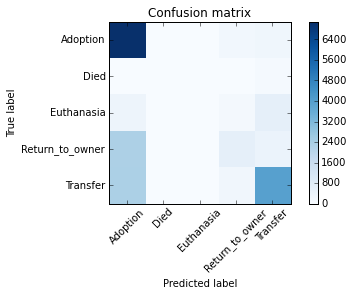

In [150]:
train_data = X_train
# This is to make use of the fit_model function above without too much modification.
train_labels = pd.DataFrame(y_train, dtype='category')['OutcomeType']
ypp = fit_model(lr)

### Feature Set V2

In [153]:
all_data = pd.concat((train, test), axis=0, ignore_index=True)

In [154]:
all_data['OutcomeType']= all_data['OutcomeType'].str.lower()
all_data['OutcomeType']= all_data['OutcomeType'].str.strip()
all_data['OutcomeType']= all_data['OutcomeType'].astype('category')
#11456 null values in the outcome type; all correspond to test data
print "Null values in OutcomeType:", sum(pd.isnull(all_data['OutcomeType'])) 

Null values in OutcomeType: 11456


**Name, AnimalType,SexUponoutcome*** are recoded to categories and dummy variables created where necessary

In [155]:
#does it have a name?
all_data['Name'] = all_data['Name'].str.strip()
all_data['Hasname'] = all_data['Name'].map(lambda x: 1 if not pd.isnull(x) and x else 0)
print all_data['Hasname'].value_counts()

1    27269
0    10916
Name: Hasname, dtype: int64


In [156]:
all_data['AnimalType'] = all_data['AnimalType'].str.lower()
all_data['AnimalType'] = all_data['AnimalType'].str.strip()
all_data['Iscat'] = all_data['AnimalType'].map(lambda x: 1 if x=='cat' else 0)
#no missing values
print "Null Values in AnimalType:", sum(pd.isnull(all_data['Iscat']))  

Null Values in AnimalType: 0


**For age**, create 2 variables: 
- one a continuous float value for age in years 
- the other a categorical value for various life stages.

In [157]:
all_data['SexuponOutcome'] = all_data['SexuponOutcome'].str.lower()
all_data['SexuponOutcome'] = all_data['SexuponOutcome'].str.strip()
all_data['SexuponOutcome'] = all_data['SexuponOutcome'].astype('category')
print all_data['SexuponOutcome'].value_counts()
#missing value, convert to Unknown category
all_data['SexuponOutcome'][pd.isnull(all_data['SexuponOutcome'])] = "unknown"
print "Null values in SexuponOutcome:", sum(pd.isnull(all_data['SexuponOutcome']))

all_data = pd.concat((all_data,pd.get_dummies(all_data['SexuponOutcome'])), axis=1)

neutered male    14014
spayed female    12633
intact female     5004
intact male       4985
unknown           1548
dtype: int64
Null values in SexuponOutcome: 0


In [158]:
all_data['AgeuponOutcome'] = all_data['AgeuponOutcome'].str.lower()
all_data['AgeuponOutcome'] = all_data['AgeuponOutcome'].str.strip()
all_data['Ageyears'] = map(age_years_2, all_data['AgeuponOutcome'])
all_data['Ageyears'].describe()

#24 values are unknkown
print "Null values in AgeuponOutcome:", sum(pd.isnull(all_data['AgeuponOutcome'])) 
#all nulls were coded to 0
print "Null values in Ageyears:", sum(pd.isnull(all_data['Ageyears'])) 

Null values in AgeuponOutcome: 24
Null values in Ageyears: 0


In [159]:

#create cat and dog age categories 
#source - http://www.akc.org/learn/family-dog/how-to-calculate-dog-years-to-human-years/
#http://icatcare.org/advice/how-guides/how-tell-your-cat%E2%80%99s-age-human-years
age_labels_dogs=['baby', 'adolescent', 'adult', 'senior']
age_ranges_dogs=[0.0, 1.0, 2.0, 7.0, 30.0]
age_ranges_cats=[0.0, 0.5, 2.0, 6.0, 10.0,15.0, 30.0]
age_labels_cats=['baby', 'adolescent', 'adult','mature', 'senior', 'geriatric']


#compute the dog age and cat age categories separately, then merge them
all_data['dog_ages'] = pd.cut(all_data['Ageyears'][all_data['AnimalType']=='dog'], age_ranges_dogs,  labels=age_labels_dogs)
all_data['cat_ages'] = pd.cut(all_data['Ageyears'][all_data['AnimalType']=='cat'], age_ranges_cats,  labels=age_labels_cats)
#merge
all_data['Agecategory'] = [all_data['dog_ages'][x] 
                               if not pd.isnull(all_data['dog_ages'][x]) 
                               else all_data['cat_ages'][x] 
                                   for x in range(all_data['dog_ages'].size)]

all_data['Agecategory'] = all_data['Agecategory'].astype('category')
print all_data['Agecategory'].value_counts()

#drop the temp columns
all_data.drop(['dog_ages', 'cat_ages'], axis=1, inplace=True)

#the AgeuponOutcome had 24 missing values, whereas the Agecategory has 59. The extra nulls are due to age=0
print "Null values in Agecategory:", sum(pd.isnull(all_data['Agecategory']))
#all_data['AgeuponOutcome'][pd.isnull(all_data['Agecategory'])]

all_data = pd.concat((all_data, pd.get_dummies(all_data['Agecategory'])), axis=1)


baby          20346
adolescent     7742
adult          7030
senior         2342
mature          624
geriatric        42
dtype: int64
Null values in Agecategory: 59


**Datetime field** is split up into several numerical variables, and one categorical variable AM/PM.
- Hour of day [00,23]
- Day of the week (0=Sunday,1=Monday, ..)
- Day of the month [00,32]
- Month [00-12]
- Week of the year [00,53]
- Two digit year

In [160]:
all_data['Hour'] = all_data.DateTime.apply(lambda d: d.strftime('%H')).astype('int') # [00,23]
all_data['Ampm'] = all_data.DateTime.apply(lambda d: d.strftime('%p')) # Am/pm
all_data['Dayofweek'] = all_data.DateTime.apply(lambda d: d.strftime('%w')).astype('int') # [0(sunday),6]
all_data['Dayofmonth'] = all_data.DateTime.apply(lambda d: d.strftime('%d')).astype('int') # 01,02,..31
all_data['Month'] = all_data.DateTime.apply(lambda d: d.strftime('%m')).astype('int')   # Month as a number
all_data['Weekofyear'] = all_data.DateTime.apply(lambda d: d.strftime('%U')).astype('int')  # [00,53]
all_data['Year'] = all_data.DateTime.apply(lambda d: d.strftime('%y')).astype('int') # two digit year

all_data.Hour.value_counts()
all_data.Ampm.value_counts()
all_data.Dayofweek.value_counts()
all_data.Dayofmonth.value_counts()
all_data.Month.value_counts()
all_data.Weekofyear.value_counts()
all_data.Year.value_counts()

dummies = pd.get_dummies(all_data['Ampm'])
all_data = pd.concat((all_data, dummies), axis=1)

**Breed and Color** are coded in 2 separate ways:
1. Create a categorical meta variable for breed (purebreed, mixed, etc) and color (single, double, etc)
2. Use CountVectorizer to encode Breed and Color. 

Whereas Breed has around 138 unique categories and color has 366, once they are vectorized we get around 200 breed-related featues and 32 color-related features.

In [161]:
all_data['Breed'] = all_data['Breed'].str.lower()
all_data['Breed'] = all_data['Breed'].str.strip()

#breed type
all_data['Breedtype'] = all_data['Breed'].map(get_breed_1)
all_data['Breedtype'].value_counts()

all_data = pd.concat((all_data, pd.get_dummies(all_data['Breedtype'])), axis=1)

all_data['Color'] = all_data['Color'].str.lower()
all_data['Color'] = all_data['Color'].str.strip()

all_data['Colortype'] = all_data['Color'].map(get_color)
all_data['Colortype'].value_counts()

#no missing values
print "Null values in Color:", sum(pd.isnull(all_data['Color']))
print "Null values in ColorType:", sum(pd.isnull(all_data['Colortype']))

all_data = pd.concat((all_data, pd.get_dummies(all_data['Colortype'], prefix='col')), axis=1)


Null values in Color: 0
Null values in ColorType: 0


In [162]:
vec = CountVectorizer(min_df=10)
breeds = vec.fit_transform(all_data['Breed'])
breeds = breeds.toarray()
breeds.shape
#create new features from breed names
for ii in range(breeds.shape[1]):
    colname = 'breed_%d' %ii
    all_data[colname] = pd.Series(breeds[:,ii])

#--------------------------------------------------------------------------------------------------


vec = CountVectorizer(min_df=10)
colors = vec.fit_transform(all_data['Color'])
colors = colors.toarray()
colors.shape
#create new features from breed names
for ii in range(colors.shape[1]):
    colname = 'color_%d' %ii
    all_data[colname] = pd.Series(colors[:,ii])

######  That's it for feature engineering. Now split the train and test data back.

In [163]:
train_data = all_data.iloc[:train_num]
test_data = all_data.iloc[train_num:]
test_ids = all_data['ID'][train_num:].values
train_labels = train_data.OutcomeType

print "train data:", train_data.shape, "Test data:", test_data.shape


train data: (26729, 258) Test data: (11456, 258)


In [164]:
#drop the columns we don't need
cols_recoded = [
 'AgeuponOutcome',
 'AnimalType',
 'Breed',
 'Color',
 'DateTime',
 'Name',
 'SexuponOutcome',
 'Agecategory',
 'Breedtype',
 'Colortype',
 'unknown',
 'Ampm']


train_data = train_data.drop(cols_recoded, axis=1)
test_data = test_data.drop(cols_recoded, axis=1)

other_cols = [
    'ID',
    'OutcomeSubtype',
    'OutcomeType']

train_data = train_data.drop(other_cols, axis=1)
test_data = test_data.drop(other_cols, axis=1)

Log Loss (each iteration) :
0.866571206011
0.873125987636
0.847760488281
0.876849516622
0.857631764855
0.862067369603
Std Deviation Log Loss :
0.00968689872444
             precision    recall  f1-score   support

   adoption       0.66      0.83      0.74     10769
       died       0.00      0.00      0.00       197
 euthanasia       0.60      0.06      0.11      1555
return_to_owner       0.48      0.44      0.46      4786
   transfer       0.73      0.67      0.70      9422

avg / total       0.64      0.65      0.63     26729

Confusion matrix, without normalization
[[8929    0    4 1192  644]
 [  19    0    4   11  163]
 [ 205    0   92  346  912]
 [2017    0   23 2095  651]
 [2331    0   31  704 6356]]


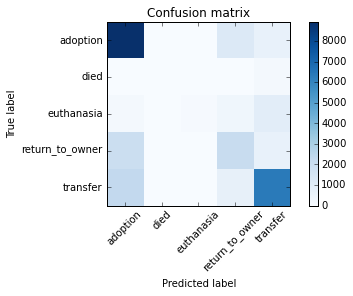

In [165]:
#plain and simple
clf = LogisticRegression()
fit_model(clf)

Log Loss (each iteration) :
0.864945898836
0.871342982972
0.845638976579
0.874861226758
0.858046260043
0.859654312384
Std Deviation Log Loss :
0.00956700176051
             precision    recall  f1-score   support

   adoption       0.66      0.83      0.74     10769
       died       0.00      0.00      0.00       197
 euthanasia       0.61      0.06      0.10      1555
return_to_owner       0.48      0.44      0.46      4786
   transfer       0.73      0.68      0.70      9422

avg / total       0.65      0.65      0.63     26729

Confusion matrix, without normalization
[[8942    0    4 1191  632]
 [  20    0    4   11  162]
 [ 209    0   86  349  911]
 [2028    0   20 2096  642]
 [2337    0   26  699 6360]]


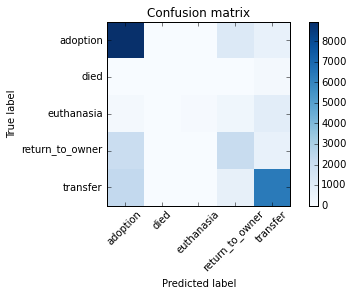

In [166]:
#with L1 regularization
clf = LogisticRegression(penalty="l1")
fit_model(clf)

Log Loss (each iteration) :
0.812653331362
0.814555368901
0.792427720046
0.831743262894
0.793576732398
0.814144515308
Std Deviation Log Loss :
0.0135161142235
             precision    recall  f1-score   support

   adoption       0.69      0.84      0.76     10769
       died       0.67      0.03      0.06       197
 euthanasia       0.63      0.13      0.22      1555
return_to_owner       0.51      0.46      0.48      4786
   transfer       0.75      0.72      0.74      9422

avg / total       0.68      0.68      0.66     26729

Confusion matrix, without normalization
[[9000    0   13 1057  699]
 [  19    6    5   12  155]
 [ 221    0  202  335  797]
 [1960    0   31 2212  583]
 [1776    3   72  763 6808]]


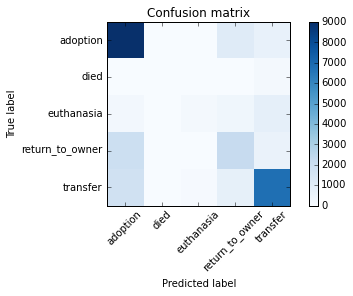

In [167]:
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
fit_model(clf)

Top features: 
['Ageyears' 'Hour' 'Dayofmonth' 'Weekofyear' 'Dayofweek' 'Month' 'Hasname'
 'spayed female' 'neutered male' 'Year' 'intact female' 'intact male'
 'baby' 'color_1' 'color_4' 'Iscat' 'color_31' 'breed_60' 'breed_148'
 'adult' 'adolescent' 'col_single_color' 'col_double_color' 'color_25'
 'senior' 'PM' 'AM' 'color_2' 'color_24' 'purebreed_mix' 'breed_104'
 'breed_29' 'breed_119' 'breed_40' 'breed_131' 'breed_165' 'color_19'
 'purebreed_purebreed' 'color_3' 'breed_90' 'purebreed' 'breed_144'
 'color_30' 'breed_52' 'breed_71' 'color_7' 'breed_94' 'color_17' 'breed_9'
 'color_8']


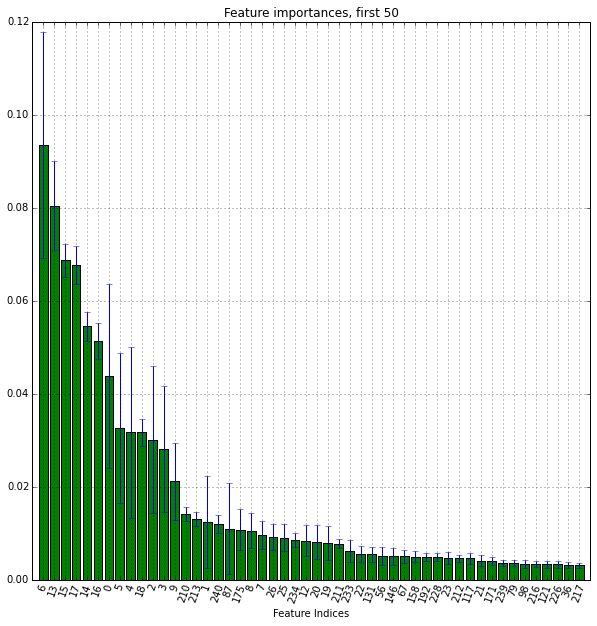

In [168]:
draw_rf_importances(clf)

## Feature Set V3

In [173]:
feature_columns = ['AnimalID', 'Name', 'DateTime', 'AnimalType', 'SexuponOutcome', 
                    'AgeuponOutcome', 'Breed', 'Color']

train_features = train.loc[:, feature_columns]
n_train_features = len(train_features.index)
print 'Train data count: {}'.format(n_train_features)

test_features = test.loc[:, feature_columns]
n_test_features = len(test_features.index)
print 'Test data count: {}'.format(n_test_features)

features = pd.concat((train_features, test_features), ignore_index=True)
print 'Total data count: {}'.format(len(features.index))

Train data count: 26729
Test data count: 11456
Total data count: 38185


#### Whether or not the animal has a name

In [174]:
features['HasName'] = features.Name.notnull().astype(float)

#### Whether the animal is a dog or a cat. (Default is cat)

In [175]:
# features['IsDog'] = (features.AnimalType == 'Dog').astype(float)
# # features.drop('AnimalType', axis=1, inplace=True)
# features.head(5)

#### Sex and spay/neuter statusa

In [176]:
# Cleaning sex
# When sex is unknown, code "None" for both Sex and Fixed values. 
# This will get handled later when dummy-coding variables. The default
# will be the "unknown" case and there will be separate features for
# both male/female and fixed/intact (for a total of 4 dummy variables).
features.loc[(features.SexuponOutcome == 'Unknown'), 'SexuponOutcome'] = None
features['Sex'] = features.SexuponOutcome.str.split(' ').str[1]
features['IsFixed'] = features.SexuponOutcome.str.split(' ').str[0]
features.loc[(features.IsFixed.str.contains('Neutered|Spayed',na=False)), 'IsFixed'] = 'Fixed'

features.loc[(features.Sex.isnull()), 'Sex'] = 'Unknown'
features.loc[(features.IsFixed.isnull()), 'IsFixed'] = 'Unknown'
#features.drop('SexuponOutcome', axis=1, inplace=True)

#### Age - convert to continuous # of years

In [186]:
# Cleaning age
# Unknown values left as NaN
# Otherwise, age is converted to years.  (Note precision loss as unit reported grows)
features['AgeNum'] = pd.to_numeric(features['AgeuponOutcome'].str.split(' ').str[0])
features['AgeUnit'] = features['AgeuponOutcome'].str.split(' ').str[1]
features.loc[(features.AgeUnit.str.contains('year', na=False)), 'Age'] = features.AgeNum / 1.0
features.loc[(features.AgeUnit.str.contains('month', na=False)), 'Age'] = features.AgeNum / 12.0
features.loc[(features.AgeUnit.str.contains('week', na=False)), 'Age'] = features.AgeNum / (365.25 / 7)
features.loc[(features.AgeUnit.str.contains('day', na=False)), 'Age'] = features.AgeNum / 365.25
# features.drop(['AgeuponOutcome', 'AgeNum', 'AgeUnit'], axis=1, inplace=True)
features.drop(['AgeNum', 'AgeUnit'], axis=1, inplace=True)

# Adding a column to flag when the real age is not known
features['AgeUnknown'] = features.AgeuponOutcome.isnull().astype(float)

# Filling NA ages with per-species mean, which should hopefully at least get us an unbiased fill-in value
cat_mean_age = features.loc[((features.AgeuponOutcome.notnull()) & (features.AnimalType == 'Cat')), 'Age'].mean()
print 'Filling NA ages for cats with mean age: {}'.format(cat_mean_age)
features.loc[((features.AgeuponOutcome.isnull()) & (features.AnimalType == 'Cat')), 'Age'] = cat_mean_age

dog_mean_age = features.loc[((features.AgeuponOutcome.notnull()) & (features.AnimalType == 'Dog')), 'Age'].mean()
print 'Filling NA ages for dogs with mean age: {}'.format(dog_mean_age)
features.loc[((features.AgeuponOutcome.isnull()) & (features.AnimalType == 'Dog')), 'Age'] = dog_mean_age

features['AgeSquared'] = features.Age * features.Age
features['LogAge'] = np.log(features.Age + 1)

print 'Minimum age: {}'.format(features.Age.min())
print 'Maximum age: {}'.format(features.Age.max())

## Rescaling age features
## Commented out 'cuz it doesn't seem to help much
# max_age = features.Age.max()
# features.Age = features.Age / max_age

# max_squared_age = features.AgeSquared.max()
# features.AgeSquared = features.AgeSquared / max_squared_age

# max_log_age = features.LogAge.max()
# features.LogAge = features.LogAge / max_log_age

#features.head(2)

Filling NA ages for cats with mean age: 1.35603498774
Filling NA ages for dogs with mean age: 2.73844387021
Minimum age: 0.0
Maximum age: 22.0


In [187]:
# Cleaning breed
# First just extracting whether it's a mix or not
features['IsMix'] = features.Breed.str.contains('Mix|/').astype(float)

features['CleanBreed'] = features.Breed.str.replace(' Mix', '')
features['BreedBits'] = features.CleanBreed.str.split('/')

features['Breed1'] = features.BreedBits.str[0]
features['Breed2'] = features.loc[features.Breed.str.contains('/')].BreedBits.str[1]
features.loc[(features.Breed2.isnull()), 'Breed2'] = 'None'


#features.head(2)

In [191]:
# Leaving month and day as strings because I think they make more sense as categorical variables
# than ordinal ones. For example, is January really "less than" December? It comes after it.
# This will make the feature count larger since we have to do so much dummy coding, but it makes
# it possible to have the model pick up on spikes that might not be related to the day's number
# in any linear way - e.g., if there's a spike of activity at the beginning and end of each month.
# 
# One issue there, though, is that it becomes a poor proxy for time in relation to the end of the
# month, since months can be anywhere from 28-31 days long. I don't know that that will really 
# matter much, though, unless there is a hard spike on certain times. If I get bored I'll do
# some plotting to look into that.
# 
# Leaving year out of it because it'll create an extrapolation issue - we can't really use fixed
# effects from past years to apply to future years.
#
# For time, I'm just getting hour of the day. I'm not sure there's much sense to 
# having greater resolution than that


features['Month'] = features.DateTime.apply(lambda d: d.strftime('%B'))   # 'January', 'Feburary', . . .
features['Day'] = features.DateTime.apply(lambda d: d.strftime('Day%d'))  # 'Day01', 'Day02', . . .
features['WeekDay'] = features.DateTime.apply(lambda d: d.strftime('%A')) # 'Sunday', 'Monday', . . .  
features['Hour'] = features.DateTime.apply(lambda d: d.strftime('Hour%H')) # 'Hour00', 'Hour01', . . . 

# features.drop(['DateTime'], axis=1, inplace=True)

#features.head(2)

In [192]:
# Pulling out separate features for merle/tick/tabby/brindle/point
features['IsMerle'] = features.Color.str.contains('Merle').astype(float)
features['IsTick'] = features.Color.str.contains('Tick').astype(float)
features['IsTabby'] = features.Color.str.contains('Tabby').astype(float)
features['IsBrindle'] = features.Color.str.contains('Brindle').astype(float)
features['IsPoint'] = features.Color.str.contains('Point').astype(float)
features['IsTiger'] = features.Color.str.contains('Tiger').astype(float)

# Then remove them
features['CleanColor'] = features.Color.str.replace(' (Merle|Tick|Tabby|Brindle|Point|Tiger)', '')
features['ColorBits'] = features.CleanColor.str.split('/')

# And split to get rest
features['Color1'] = features.ColorBits.str[0]
features['Color2'] = features.loc[features.Color.str.contains('/')].ColorBits.str[1]
features.loc[(features.Color2.isnull()), 'Color2'] = 'None'


#features.loc[features.Color.str.contains('/')].head(10)
#features.head(5)

## Creating interaction variables
##### I'm going to go overboard here

## Coding data (using patsy)

In [195]:
# Pretty complete - as of 4/20 this is the one I used for the Kaggle submission
# data = dmatrix('AnimalType + HasName + Sex + IsFixed + Age + AgeUnknown + AgeSquared + LogAge ' +
#                '+ IsMix + Month + WeekDay + IsMerle + IsTick + IsTabby + IsBrindle ' +
#                '+ IsPoint + IsTiger ' +
#                '+ AnimalType:HasName + AnimalType:Sex + AnimalType:IsFixed + AnimalType:Age ' +
#                '+ AnimalType:AgeSquared + AnimalType:LogAge + AnimalType:IsMix + AnimalType:Month ' +
#                '+ AnimalType:WeekDay ' +
#                '+ Sex:IsFixed + Sex:IsMix ' +
#                '+ Breed1 + Breed2 + Color1 + Color2',  
#                features, return_type='dataframe', NA_action='raise')
 
# plus a bunch of other interactions
data = dmatrix('AnimalType + HasName + Sex + IsFixed + Age + AgeUnknown + AgeSquared + LogAge ' +
               '+ IsMix + Month + WeekDay + IsMerle + IsTick + IsTabby + IsBrindle ' +
               '+ IsPoint + IsTiger ' +
               '+ AnimalType:HasName + AnimalType:Sex + AnimalType:IsFixed + AnimalType:Age ' +
               '+ AnimalType:AgeSquared + AnimalType:LogAge + AnimalType:IsMix ' + 
               '+ AnimalType:Month + AnimalType:WeekDay ' +
               '+ AnimalType:Sex:IsFixed + AnimalType:Sex:Age + AnimalType:Sex:IsMix ' +
               '+ AnimalType:IsFixed:IsMix + AnimalType:Sex:IsFixed:IsMix ' +
               '+ Sex:IsFixed + Sex:IsMix ' +
               '+ IsFixed:IsMix ' +
               '+ Breed1 + Breed2 + Color1 + Color2',  
               features, return_type='dataframe', NA_action='raise')

In [196]:
# I've tried to keep it so that the dtype of all the columns we want to use
# for training is float64, so we can just grab those
numeric_features = data.loc[:, (data.dtypes == np.float64) | (data.dtypes == np.int64)]

#print data.dtypes

print 'Feature count: {}'.format(len(numeric_features.dtypes))

Feature count: 536


In [197]:
train_data = numeric_features[:n_train_features]
n_train_data = len(train_data.index)

test_data = numeric_features[n_train_features:]
n_test_data = len(test_data.index)

print '# train rows is {} (should be {})'.format(n_train_data, n_train_features)
print '# test rows is {} (should be {})'.format(n_test_data, n_test_features)

# train rows is 26729 (should be 26729)
# test rows is 11456 (should be 11456)


In [199]:
# Using 80-20 split
labels = train.OutcomeType

train_set, test_set, train_labels, test_labels = \
    train_test_split(train_data, labels, test_size=0.2)
    
print train_set.shape
print test_set.shape
print train_labels.shape
print test_labels.shape

(21383, 536)
(5346, 536)
(21383,)
(5346,)


In [202]:
train_data = train_set
# This is to make use of the fit_model function above without too much modification.
train_labels = pd.DataFrame(train_labels, dtype='category')['OutcomeType']

Log Loss (each iteration) :
0.825641958932
0.89425173381
0.841856226059
0.8782911607
0.8889188629
0.877460858614
Std Deviation Log Loss :
0.025164303757
             precision    recall  f1-score   support

   Adoption       0.67      0.82      0.74      8661
       Died       0.29      0.03      0.06       162
 Euthanasia       0.45      0.11      0.18      1244
Return_to_owner       0.47      0.46      0.47      3771
   Transfer       0.73      0.65      0.69      7545

avg / total       0.64      0.65      0.64     21383

Confusion matrix, without normalization
[[7123    2    7  951  578]
 [  19    5    9    9  120]
 [ 159    2  141  290  652]
 [1492    0   36 1745  498]
 [1763    8  119  737 4918]]


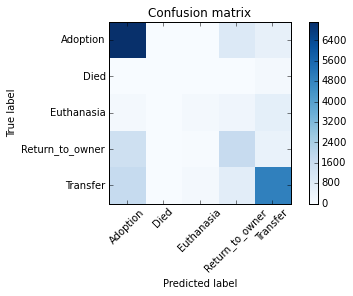

In [203]:
#target: .8278 @ d=24, n=2000
clf = RandomForestClassifier(n_estimators=1000, n_jobs=4, max_depth=31)
fit_model(clf)

Top features: 
['Age' 'AgeSquared' 'LogAge' 'IsFixed[T.Intact]' 'IsFixed[T.Intact]:IsMix'
 'HasName' 'AnimalType[T.Dog]:Age' 'AnimalType[T.Dog]:LogAge'
 'AnimalType[T.Dog]:AgeSquared' 'Color2[T.None]'
 'AnimalType[Cat]:Sex[T.Male]:Age' 'Color2[T.White]'
 'AnimalType[T.Dog]:HasName' 'Color1[T.Black]'
 'AnimalType[Dog]:Sex[T.Male]:Age' 'Sex[T.Male]:IsFixed[T.Intact]'
 'Color1[T.Brown]' 'AnimalType[T.Dog]:IsFixed[T.Intact]'
 'WeekDay[T.Saturday]' 'WeekDay[T.Sunday]' 'WeekDay[T.Monday]'
 'WeekDay[T.Tuesday]' 'WeekDay[T.Thursday]' 'WeekDay[T.Wednesday]'
 'Month[T.November]' 'Month[T.October]' 'Month[T.December]'
 'AnimalType[T.Dog]:IsFixed[T.Intact]:IsMix' 'Color1[T.White]'
 'Color1[T.Blue]' 'Month[T.July]' 'Month[T.June]' 'Breed1[T.Pit Bull]'
 'Month[T.January]' 'AnimalType[Cat]:Sex[T.Male]:IsFixed[T.Intact]:IsMix'
 'Breed1[T.Domestic Shorthair]' 'Month[T.May]' 'Month[T.August]'
 'Breed1[T.Chihuahua Shorthair]' 'Month[T.September]' 'IsTabby'
 'Breed2[T.None]' 'AnimalType[T.Dog]:IsMix' 'Mon

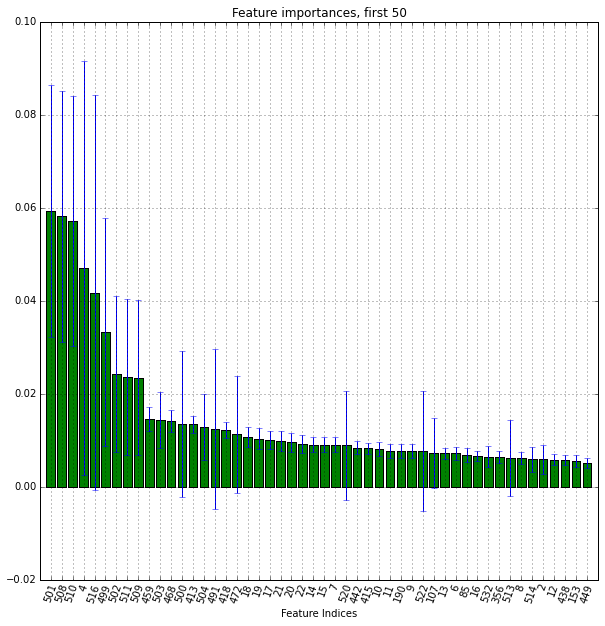

In [204]:
draw_rf_importances(clf)